In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil

In [2]:
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

In [3]:
# Resample function to balance each class to 500 samples
def resample_data(directory, target_count=500):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)
                
def resample_data1(directory, target_count=300):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)

In [4]:
## Resample training data
#resample_data(train_dir)
#resample_data1(val_dir)


# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3500 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.


In [5]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import os

# Load the VGG16 model without the top fully connected layers (include_top=False)
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers[-30:]:
    layer.trainable = False
    
## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model with L2 regularization
x = base_model.output
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)

# Add Dense layers with L2 regularization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(7, activation='softmax', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)

# Final output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 299, 224, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 299, 224, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save the best model
checkpoint = ModelCheckpoint(
    'InceptionResNetV2.1.h5',       # Path to save the model
    monitor='val_loss',     # Metric to monitor ('val_loss' or 'val_accuracy')
    save_best_only=True,    # Save only the best model
    mode='min',             # Save model when the validation loss decreases ('min' for loss, 'max' for accuracy)
    verbose=1
)

# Train the model with ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback, checkpoint, reduce_lr],
    verbose=2
)


Epoch 1/1000
126/126 [==============================] - 36s 270ms/step
Epoch 1 - Validation Loss: 4.1658, Validation Accuracy: 0.2823, Validation Precision: 0.4966

Epoch 1: val_loss improved from inf to 4.16583, saving model to InceptionResNetV2.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 282s - loss: 4.7991 - acc: 0.1849 - val_loss: 4.1658 - val_acc: 0.2823 - lr: 1.0000e-04 - 282s/epoch - 1s/step
Epoch 2/1000
126/126 [==============================] - 34s 270ms/step
Epoch 2 - Validation Loss: 3.1698, Validation Accuracy: 0.5032, Validation Precision: 0.6466

Epoch 2: val_loss improved from 4.16583 to 3.16985, saving model to InceptionResNetV2.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 255s - loss: 3.6371 - acc: 0.2597 - val_loss: 3.1698 - val_acc: 0.5032 - lr: 1.0000e-04 - 255s/epoch - 1s/step
Epoch 3/1000
126/126 [==============================] - 34s 270ms/step
Epoch 3 - Validation Loss: 2.7827, Validation Accuracy: 0.4878, Validation Precision: 0.6330

Epoch 3: val_loss improved from 3.16985 to 2.78272, saving model to InceptionResNetV2.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 3.0696 - acc: 0.2989 - val_loss: 2.7827 - val_acc: 0.4878 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 4/1000
126/126 [==============================] - 34s 270ms/step
Epoch 4 - Validation Loss: 2.6991, Validation Accuracy: 0.1815, Validation Precision: 0.6656

Epoch 4: val_loss improved from 2.78272 to 2.69907, saving model to InceptionResNetV2.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 2.7202 - acc: 0.3037 - val_loss: 2.6991 - val_acc: 0.1815 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 5/1000
126/126 [==============================] - 34s 269ms/step
Epoch 5 - Validation Loss: 2.3462, Validation Accuracy: 0.5057, Validation Precision: 0.6631

Epoch 5: val_loss improved from 2.69907 to 2.34619, saving model to InceptionResNetV2.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 2.5061 - acc: 0.3106 - val_loss: 2.3462 - val_acc: 0.5057 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 6/1000
126/126 [==============================] - 34s 269ms/step
Epoch 6 - Validation Loss: 2.1975, Validation Accuracy: 0.5052, Validation Precision: 0.7010

Epoch 6: val_loss improved from 2.34619 to 2.19751, saving model to InceptionResNetV2.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 2.3482 - acc: 0.3209 - val_loss: 2.1975 - val_acc: 0.5052 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 7/1000
126/126 [==============================] - 34s 269ms/step
Epoch 7 - Validation Loss: 2.1273, Validation Accuracy: 0.4713, Validation Precision: 0.7040

Epoch 7: val_loss improved from 2.19751 to 2.12732, saving model to InceptionResNetV2.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 2.2384 - acc: 0.3340 - val_loss: 2.1273 - val_acc: 0.4713 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 8/1000
126/126 [==============================] - 34s 270ms/step
Epoch 8 - Validation Loss: 2.1244, Validation Accuracy: 0.3761, Validation Precision: 0.6964

Epoch 8: val_loss improved from 2.12732 to 2.12436, saving model to InceptionResNetV2.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 255s - loss: 2.1463 - acc: 0.3417 - val_loss: 2.1244 - val_acc: 0.3761 - lr: 1.0000e-04 - 255s/epoch - 1s/step
Epoch 9/1000
126/126 [==============================] - 34s 270ms/step
Epoch 9 - Validation Loss: 1.9548, Validation Accuracy: 0.5352, Validation Precision: 0.6563

Epoch 9: val_loss improved from 2.12436 to 1.95484, saving model to InceptionResNetV2.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 2.0894 - acc: 0.3226 - val_loss: 1.9548 - val_acc: 0.5352 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 10/1000
126/126 [==============================] - 34s 269ms/step
Epoch 10 - Validation Loss: 1.9736, Validation Accuracy: 0.4414, Validation Precision: 0.6951

Epoch 10: val_loss did not improve from 1.95484
219/219 - 253s - loss: 2.0404 - acc: 0.3317 - val_loss: 1.9736 - val_acc: 0.4414 - lr: 1.0000e-04 - 253s/epoch - 1s/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 11 - Validation Loss: 1.9218, Validation Accuracy: 0.4454, Validation Precision: 0.6940

Epoch 11: val_loss improved from 1.95484 to 1.92179, saving model to InceptionResNetV2.1.h5
219/219 - 254s - loss: 1.9871 - acc: 0.3440 - val_loss: 1.9218 - val_acc: 0.4454 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 12/1000
126/126 [==============================] - 34s 269ms/step
Epoch 12 - Validation Loss: 1.8534, Validation Accuracy: 0.5022, Validation Precision: 0.7076

Epoch 12: val_loss improved from 1.92179 to 1.85343, saving model to InceptionResNetV2.1.h5
219/219 - 254s - loss: 1.9385 - acc: 0.3697 - val_loss: 1.8534 - val_acc: 0.5022 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 13/1000
126/126 [==============================] - 34s 270ms/step
Epoch 13 - Validation Loss: 1.7906, Validation Accuracy: 0.5576, Validation Precision: 0.7377

Epoch 13: val_loss improved from 1.85343 to 1.79059, saving model to InceptionResNetV2.

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 1.9161 - acc: 0.3503 - val_loss: 1.7906 - val_acc: 0.5576 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 14/1000
126/126 [==============================] - 34s 270ms/step
Epoch 14 - Validation Loss: 1.7946, Validation Accuracy: 0.5082, Validation Precision: 0.7030

Epoch 14: val_loss did not improve from 1.79059
219/219 - 253s - loss: 1.8828 - acc: 0.3489 - val_loss: 1.7946 - val_acc: 0.5082 - lr: 1.0000e-04 - 253s/epoch - 1s/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 15 - Validation Loss: 1.7314, Validation Accuracy: 0.5551, Validation Precision: 0.7330

Epoch 15: val_loss improved from 1.79059 to 1.73143, saving model to InceptionResNetV2.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 1.8510 - acc: 0.3563 - val_loss: 1.7314 - val_acc: 0.5551 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 16/1000
126/126 [==============================] - 34s 269ms/step
Epoch 16 - Validation Loss: 1.8176, Validation Accuracy: 0.4509, Validation Precision: 0.6985

Epoch 16: val_loss did not improve from 1.73143
219/219 - 253s - loss: 1.8325 - acc: 0.3589 - val_loss: 1.8176 - val_acc: 0.4509 - lr: 1.0000e-04 - 253s/epoch - 1s/step
Epoch 17/1000
126/126 [==============================] - 34s 269ms/step
Epoch 17 - Validation Loss: 1.7712, Validation Accuracy: 0.4853, Validation Precision: 0.6931

Epoch 17: val_loss did not improve from 1.73143
219/219 - 253s - loss: 1.8328 - acc: 0.3500 - val_loss: 1.7712 - val_acc: 0.4853 - lr: 1.0000e-04 - 253s/epoch - 1s/step
Epoch 18/1000
126/126 [==============================] - 34s 269ms/step
Epoch 18 - Validation Loss: 1.7814, Validation Accuracy: 0.4643, Validation Precision: 0.7039

Epoch 18: val_loss did not improve from 

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 19 - Validation Loss: 1.7511, Validation Accuracy: 0.5112, Validation Precision: 0.7287

Epoch 19: val_loss did not improve from 1.73143
219/219 - 253s - loss: 1.8001 - acc: 0.3563 - val_loss: 1.7511 - val_acc: 0.5112 - lr: 1.0000e-04 - 253s/epoch - 1s/step
Epoch 20/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 20 - Validation Loss: 1.6476, Validation Accuracy: 0.5397, Validation Precision: 0.7208

Epoch 20: val_loss improved from 1.73143 to 1.64764, saving model to InceptionResNetV2.1.h5
219/219 - 254s - loss: 1.7835 - acc: 0.3634 - val_loss: 1.6476 - val_acc: 0.5397 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 21/1000
126/126 [==============================] - 34s 270ms/step
Epoch 21 - Validation Loss: 1.6676, Validation Accuracy: 0.5337, Validation Precision: 0.7154

Epoch 21: val_loss did not improve from 1.64764
219/219 - 253s - loss: 1.7562 - acc: 0.3649 - val_loss: 1.6676 - val_acc: 0.5337 - lr: 1.0000e-04 - 253s/epoch - 1s/step
Epoch 22/1000
126/126 [==============================] - 34s 269ms/step
Epoch 22 - Validation Loss: 1.6138, Validation Accuracy: 0.5676, Validation Precision: 0.6969

Epoch 22: val_loss improved from 1.64764 to 1.61384, saving model to InceptionResNetV2.1.h5
219/219 - 254s - loss: 1.7385 - acc: 0.

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 25 - Validation Loss: 1.6724, Validation Accuracy: 0.4958, Validation Precision: 0.7695

Epoch 25: val_loss did not improve from 1.61384
219/219 - 253s - loss: 1.6896 - acc: 0.3734 - val_loss: 1.6724 - val_acc: 0.4958 - lr: 1.0000e-04 - 253s/epoch - 1s/step
Epoch 26/1000
126/126 [==============================] - 34s 269ms/step
Epoch 26 - Validation Loss: 1.6589, Validation Accuracy: 0.5227, Validation Precision: 0.7080

Epoch 26: val_loss did not improve from 1.61384
219/219 - 253s - loss: 1.6851 - acc: 0.3731 - val_loss: 1.6589 - val_acc: 0.5227 - lr: 1.0000e-04 - 253s/epoch - 1s/step
Epoch 27/1000
126/126 [==============================] - 34s 269ms/step
Epoch 27 - Validation Loss: 1.6373, Validation Accuracy: 0.5501, Validation Precision: 0.7335

Epoch 27: val_loss did not improve from 1.61384
219/219 - 253s - loss: 1.6776 - acc: 0.3766 - val_loss: 1.6373 - val_acc: 0.5501 - lr: 1.0000e-04 - 253s/epoch - 1s/step
Epoch 

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 33 - Validation Loss: 1.7116, Validation Accuracy: 0.4738, Validation Precision: 0.7510

Epoch 33: val_loss did not improve from 1.58580
219/219 - 253s - loss: 1.5995 - acc: 0.3874 - val_loss: 1.7116 - val_acc: 0.4738 - lr: 5.0000e-05 - 253s/epoch - 1s/step
Epoch 34/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 34 - Validation Loss: 1.6439, Validation Accuracy: 0.5287, Validation Precision: 0.6964

Epoch 34: val_loss did not improve from 1.58580
219/219 - 253s - loss: 1.5959 - acc: 0.3966 - val_loss: 1.6439 - val_acc: 0.5287 - lr: 2.5000e-05 - 253s/epoch - 1s/step
Epoch 35/1000
126/126 [==============================] - 34s 269ms/step
Epoch 35 - Validation Loss: 1.6359, Validation Accuracy: 0.5382, Validation Precision: 0.7298

Epoch 35: val_loss did not improve from 1.58580
219/219 - 252s - loss: 1.5734 - acc: 0.3951 - val_loss: 1.6359 - val_acc: 0.5382 - lr: 2.5000e-05 - 252s/epoch - 1s/step
Epoch 36/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 36 - Validation Loss: 1.5971, Validation Accuracy: 0.5766, Validation Precision: 0.7126

Epoch 36: val_loss did not improve from 1.58580
219/219 - 253s - loss: 1.5822 - acc: 0.3943 - val_loss: 1.5971 - val_acc: 0.5766 - lr: 2.5000e-05 - 253s/epoch - 1s/step
Epoch 37/1000
126/126 [==============================] - 34s 269ms/step
Epoch 37 - Validation Loss: 1.5850, Validation Accuracy: 0.5840, Validation Precision: 0.6859

Epoch 37: val_loss improved from 1.58580 to 1.58503, saving model to InceptionResNetV2.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 1.5541 - acc: 0.4140 - val_loss: 1.5850 - val_acc: 0.5840 - lr: 2.5000e-05 - 254s/epoch - 1s/step
Epoch 38/1000
126/126 [==============================] - 34s 269ms/step
Epoch 38 - Validation Loss: 1.6258, Validation Accuracy: 0.5486, Validation Precision: 0.7327

Epoch 38: val_loss did not improve from 1.58503
219/219 - 253s - loss: 1.5494 - acc: 0.4009 - val_loss: 1.6258 - val_acc: 0.5486 - lr: 2.5000e-05 - 253s/epoch - 1s/step
Epoch 39/1000
126/126 [==============================] - 34s 269ms/step
Epoch 39 - Validation Loss: 1.6185, Validation Accuracy: 0.5446, Validation Precision: 0.7334

Epoch 39: val_loss did not improve from 1.58503
219/219 - 253s - loss: 1.5516 - acc: 0.4011 - val_loss: 1.6185 - val_acc: 0.5446 - lr: 2.5000e-05 - 253s/epoch - 1s/step
Epoch 40/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 40 - Validation Loss: 1.6356, Validation Accuracy: 0.5397, Validation Precision: 0.6916

Epoch 40: val_loss did not improve from 1.58503
219/219 - 253s - loss: 1.5530 - acc: 0.3960 - val_loss: 1.6356 - val_acc: 0.5397 - lr: 2.5000e-05 - 253s/epoch - 1s/step
Epoch 41/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 41 - Validation Loss: 1.6168, Validation Accuracy: 0.5461, Validation Precision: 0.7427

Epoch 41: val_loss did not improve from 1.58503
219/219 - 253s - loss: 1.5392 - acc: 0.4086 - val_loss: 1.6168 - val_acc: 0.5461 - lr: 2.5000e-05 - 253s/epoch - 1s/step
Epoch 42/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 42 - Validation Loss: 1.5871, Validation Accuracy: 0.5786, Validation Precision: 0.6990

Epoch 42: val_loss did not improve from 1.58503
219/219 - 253s - loss: 1.5505 - acc: 0.3983 - val_loss: 1.5871 - val_acc: 0.5786 - lr: 2.5000e-05 - 253s/epoch - 1s/step
Epoch 43/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 43 - Validation Loss: 1.6253, Validation Accuracy: 0.5397, Validation Precision: 0.7276

Epoch 43: val_loss did not improve from 1.58503
219/219 - 253s - loss: 1.5248 - acc: 0.4080 - val_loss: 1.6253 - val_acc: 0.5397 - lr: 1.2500e-05 - 253s/epoch - 1s/step
Epoch 44/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 44 - Validation Loss: 1.6091, Validation Accuracy: 0.5541, Validation Precision: 0.6913

Epoch 44: val_loss did not improve from 1.58503
219/219 - 253s - loss: 1.5227 - acc: 0.4083 - val_loss: 1.6091 - val_acc: 0.5541 - lr: 1.2500e-05 - 253s/epoch - 1s/step
Epoch 45/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 45 - Validation Loss: 1.5987, Validation Accuracy: 0.5656, Validation Precision: 0.7089

Epoch 45: val_loss did not improve from 1.58503
219/219 - 253s - loss: 1.5264 - acc: 0.4129 - val_loss: 1.5987 - val_acc: 0.5656 - lr: 1.2500e-05 - 253s/epoch - 1s/step
Epoch 46/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 46 - Validation Loss: 1.5885, Validation Accuracy: 0.5756, Validation Precision: 0.7073

Epoch 46: val_loss did not improve from 1.58503
219/219 - 253s - loss: 1.5214 - acc: 0.4091 - val_loss: 1.5885 - val_acc: 0.5756 - lr: 1.2500e-05 - 253s/epoch - 1s/step
Epoch 47/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 47 - Validation Loss: 1.5771, Validation Accuracy: 0.5796, Validation Precision: 0.7043

Epoch 47: val_loss improved from 1.58503 to 1.57714, saving model to InceptionResNetV2.1.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 1.5140 - acc: 0.4057 - val_loss: 1.5771 - val_acc: 0.5796 - lr: 1.2500e-05 - 254s/epoch - 1s/step
Epoch 48/1000
126/126 [==============================] - 34s 269ms/step
Epoch 48 - Validation Loss: 1.6199, Validation Accuracy: 0.5406, Validation Precision: 0.7072

Epoch 48: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.5212 - acc: 0.4031 - val_loss: 1.6199 - val_acc: 0.5406 - lr: 1.2500e-05 - 253s/epoch - 1s/step
Epoch 49/1000
126/126 [==============================] - 34s 269ms/step
Epoch 49 - Validation Loss: 1.6112, Validation Accuracy: 0.5506, Validation Precision: 0.6889

Epoch 49: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.5108 - acc: 0.4063 - val_loss: 1.6112 - val_acc: 0.5506 - lr: 1.2500e-05 - 253s/epoch - 1s/step
Epoch 50/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 50 - Validation Loss: 1.5812, Validation Accuracy: 0.5800, Validation Precision: 0.6857

Epoch 50: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.5205 - acc: 0.4080 - val_loss: 1.5812 - val_acc: 0.5800 - lr: 1.2500e-05 - 253s/epoch - 1s/step
Epoch 51/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 51 - Validation Loss: 1.5793, Validation Accuracy: 0.5791, Validation Precision: 0.7355

Epoch 51: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.5120 - acc: 0.4054 - val_loss: 1.5793 - val_acc: 0.5791 - lr: 1.2500e-05 - 253s/epoch - 1s/step
Epoch 52/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 52 - Validation Loss: 1.5964, Validation Accuracy: 0.5631, Validation Precision: 0.7078

Epoch 52: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4921 - acc: 0.4203 - val_loss: 1.5964 - val_acc: 0.5631 - lr: 1.2500e-05 - 253s/epoch - 1s/step
Epoch 53/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 53 - Validation Loss: 1.5930, Validation Accuracy: 0.5636, Validation Precision: 0.6884

Epoch 53: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4831 - acc: 0.4220 - val_loss: 1.5930 - val_acc: 0.5636 - lr: 6.2500e-06 - 253s/epoch - 1s/step
Epoch 54/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 54 - Validation Loss: 1.6032, Validation Accuracy: 0.5601, Validation Precision: 0.7565

Epoch 54: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4892 - acc: 0.4149 - val_loss: 1.6032 - val_acc: 0.5601 - lr: 6.2500e-06 - 253s/epoch - 1s/step
Epoch 55/1000
126/126 [==============================] - 34s 269ms/step
Epoch 55 - Validation Loss: 1.5911, Validation Accuracy: 0.5691, Validation Precision: 0.7569

Epoch 55: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4970 - acc: 0.4069 - val_loss: 1.5911 - val_acc: 0.5691 - lr: 6.2500e-06 - 253s/epoch - 1s/step
Epoch 56/1000
126/126 [==============================] - 34s 270ms/step
Epoch 56 - Validation Loss: 1.6107, Validation Accuracy: 0.5541, Validation Precision: 0.7467

Epoch 56: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4899 - acc: 0.4171 - val_loss: 1.6107 - val_acc: 0.5541 - lr: 6.2500e-06 - 253s/epoch - 1s/step
Epoch 

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 57 - Validation Loss: 1.5989, Validation Accuracy: 0.5621, Validation Precision: 0.7049

Epoch 57: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4937 - acc: 0.4109 - val_loss: 1.5989 - val_acc: 0.5621 - lr: 6.2500e-06 - 253s/epoch - 1s/step
Epoch 58/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 58 - Validation Loss: 1.6043, Validation Accuracy: 0.5546, Validation Precision: 0.6904

Epoch 58: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4873 - acc: 0.4177 - val_loss: 1.6043 - val_acc: 0.5546 - lr: 3.1250e-06 - 253s/epoch - 1s/step
Epoch 59/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 59 - Validation Loss: 1.6041, Validation Accuracy: 0.5536, Validation Precision: 0.7095

Epoch 59: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4862 - acc: 0.4154 - val_loss: 1.6041 - val_acc: 0.5536 - lr: 3.1250e-06 - 253s/epoch - 1s/step
Epoch 60/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 60 - Validation Loss: 1.6009, Validation Accuracy: 0.5606, Validation Precision: 0.7115

Epoch 60: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4788 - acc: 0.4160 - val_loss: 1.6009 - val_acc: 0.5606 - lr: 3.1250e-06 - 253s/epoch - 1s/step
Epoch 61/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 61 - Validation Loss: 1.6135, Validation Accuracy: 0.5476, Validation Precision: 0.7097

Epoch 61: val_loss did not improve from 1.57714
219/219 - 252s - loss: 1.4826 - acc: 0.4171 - val_loss: 1.6135 - val_acc: 0.5476 - lr: 3.1250e-06 - 252s/epoch - 1s/step
Epoch 62/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 62 - Validation Loss: 1.6092, Validation Accuracy: 0.5521, Validation Precision: 0.7091

Epoch 62: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4725 - acc: 0.4234 - val_loss: 1.6092 - val_acc: 0.5521 - lr: 3.1250e-06 - 253s/epoch - 1s/step
Epoch 63/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 63 - Validation Loss: 1.6101, Validation Accuracy: 0.5511, Validation Precision: 0.6912

Epoch 63: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4789 - acc: 0.4226 - val_loss: 1.6101 - val_acc: 0.5511 - lr: 1.5625e-06 - 253s/epoch - 1s/step
Epoch 64/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 64 - Validation Loss: 1.6064, Validation Accuracy: 0.5561, Validation Precision: 0.7788

Epoch 64: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4781 - acc: 0.4206 - val_loss: 1.6064 - val_acc: 0.5561 - lr: 1.5625e-06 - 253s/epoch - 1s/step
Epoch 65/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 65 - Validation Loss: 1.6087, Validation Accuracy: 0.5526, Validation Precision: 0.7139

Epoch 65: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4790 - acc: 0.4151 - val_loss: 1.6087 - val_acc: 0.5526 - lr: 1.5625e-06 - 253s/epoch - 1s/step
Epoch 66/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 66 - Validation Loss: 1.6066, Validation Accuracy: 0.5556, Validation Precision: 0.7131

Epoch 66: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4955 - acc: 0.4063 - val_loss: 1.6066 - val_acc: 0.5556 - lr: 1.5625e-06 - 253s/epoch - 1s/step
Epoch 67/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 67 - Validation Loss: 1.6122, Validation Accuracy: 0.5506, Validation Precision: 0.6915

Epoch 67: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4813 - acc: 0.4154 - val_loss: 1.6122 - val_acc: 0.5506 - lr: 1.5625e-06 - 253s/epoch - 1s/step
Epoch 68/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 68 - Validation Loss: 1.6105, Validation Accuracy: 0.5501, Validation Precision: 0.7039

Epoch 68: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4744 - acc: 0.4254 - val_loss: 1.6105 - val_acc: 0.5501 - lr: 1.0000e-06 - 253s/epoch - 1s/step
Epoch 69/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 69 - Validation Loss: 1.6073, Validation Accuracy: 0.5541, Validation Precision: 0.7226

Epoch 69: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4758 - acc: 0.4174 - val_loss: 1.6073 - val_acc: 0.5541 - lr: 1.0000e-06 - 253s/epoch - 1s/step
Epoch 70/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 70 - Validation Loss: 1.6076, Validation Accuracy: 0.5536, Validation Precision: 0.6901

Epoch 70: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4667 - acc: 0.4240 - val_loss: 1.6076 - val_acc: 0.5536 - lr: 1.0000e-06 - 253s/epoch - 1s/step
Epoch 71/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 71 - Validation Loss: 1.6086, Validation Accuracy: 0.5536, Validation Precision: 0.7280

Epoch 71: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4780 - acc: 0.4189 - val_loss: 1.6086 - val_acc: 0.5536 - lr: 1.0000e-06 - 253s/epoch - 1s/step
Epoch 72/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 72 - Validation Loss: 1.6089, Validation Accuracy: 0.5526, Validation Precision: 0.7125

Epoch 72: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4801 - acc: 0.4220 - val_loss: 1.6089 - val_acc: 0.5526 - lr: 1.0000e-06 - 253s/epoch - 1s/step
Epoch 73/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 73 - Validation Loss: 1.6047, Validation Accuracy: 0.5561, Validation Precision: 0.7353

Epoch 73: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4775 - acc: 0.4106 - val_loss: 1.6047 - val_acc: 0.5561 - lr: 1.0000e-06 - 253s/epoch - 1s/step
Epoch 74/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 74 - Validation Loss: 1.6064, Validation Accuracy: 0.5536, Validation Precision: 0.7060

Epoch 74: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4718 - acc: 0.4183 - val_loss: 1.6064 - val_acc: 0.5536 - lr: 1.0000e-06 - 253s/epoch - 1s/step
Epoch 75/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 75 - Validation Loss: 1.6028, Validation Accuracy: 0.5566, Validation Precision: 0.7046

Epoch 75: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4885 - acc: 0.4046 - val_loss: 1.6028 - val_acc: 0.5566 - lr: 1.0000e-06 - 253s/epoch - 1s/step
Epoch 76/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 76 - Validation Loss: 1.6077, Validation Accuracy: 0.5531, Validation Precision: 0.6905

Epoch 76: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4797 - acc: 0.4143 - val_loss: 1.6077 - val_acc: 0.5531 - lr: 1.0000e-06 - 253s/epoch - 1s/step
Epoch 77/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 77 - Validation Loss: 1.5997, Validation Accuracy: 0.5606, Validation Precision: 0.7043

Epoch 77: val_loss did not improve from 1.57714
219/219 - 253s - loss: 1.4825 - acc: 0.4126 - val_loss: 1.5997 - val_acc: 0.5606 - lr: 1.0000e-06 - 253s/epoch - 1s/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Calculate precision, recall, and f1 score after training
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1_score:.4f}')

126/126 [==============================] - 34s 269ms/step
Final Precision: 0.7043
Final Recall: 0.5796
Final F1 Score: 0.5912


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 26s 274ms/step - loss: 1.6015 - acc: 0.5505
Test accuracy: 0.5504950284957886


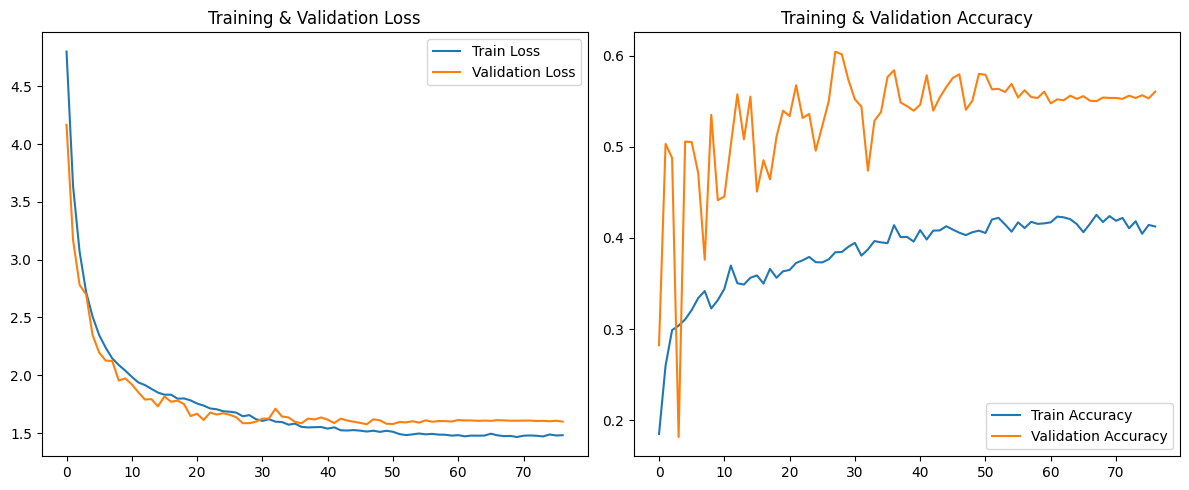

In [9]:
# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training & Validation Loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training & Validation Loss')

# Plot Training & Validation Accuracy
axs[1].plot(history.history['acc'], label='Train Accuracy')
axs[1].plot(history.history['val_acc'], label='Validation Accuracy')
axs[1].legend()
axs[1].set_title('Training & Validation Accuracy')

plt.tight_layout()
plt.show()

219/219 [==============================] - 96s 436ms/step


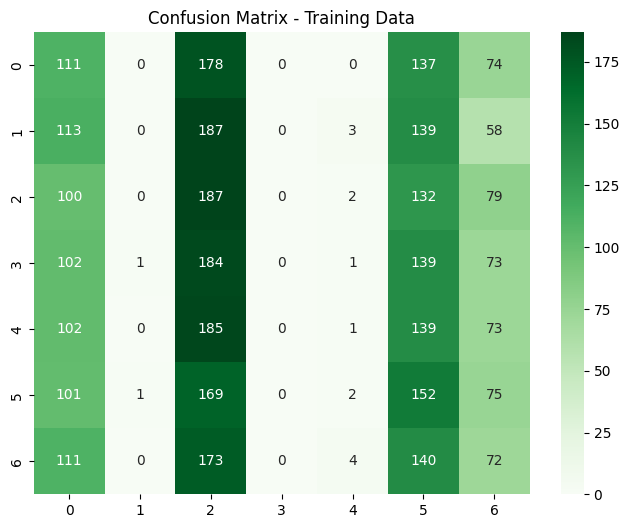

126/126 [==============================] - 34s 268ms/step


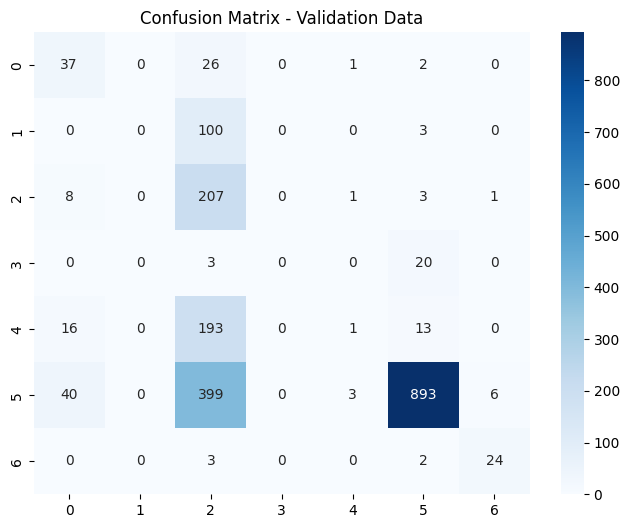

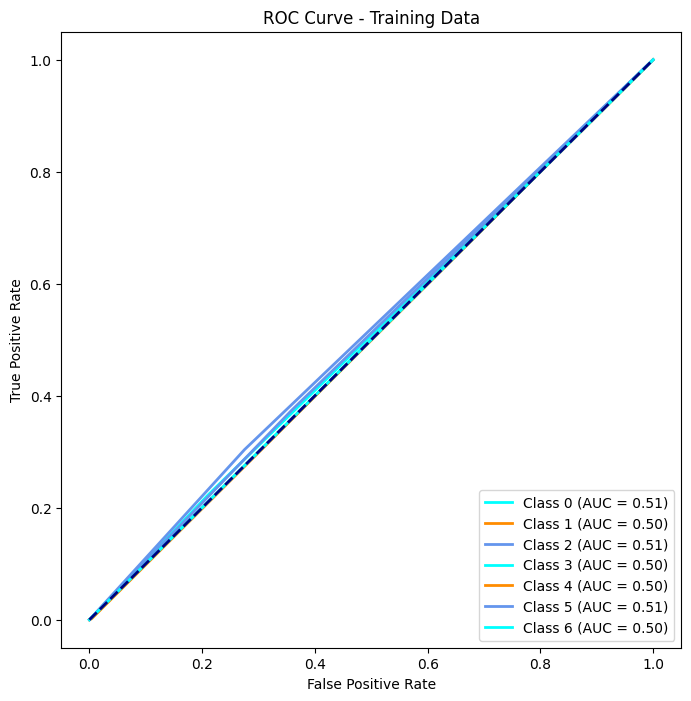

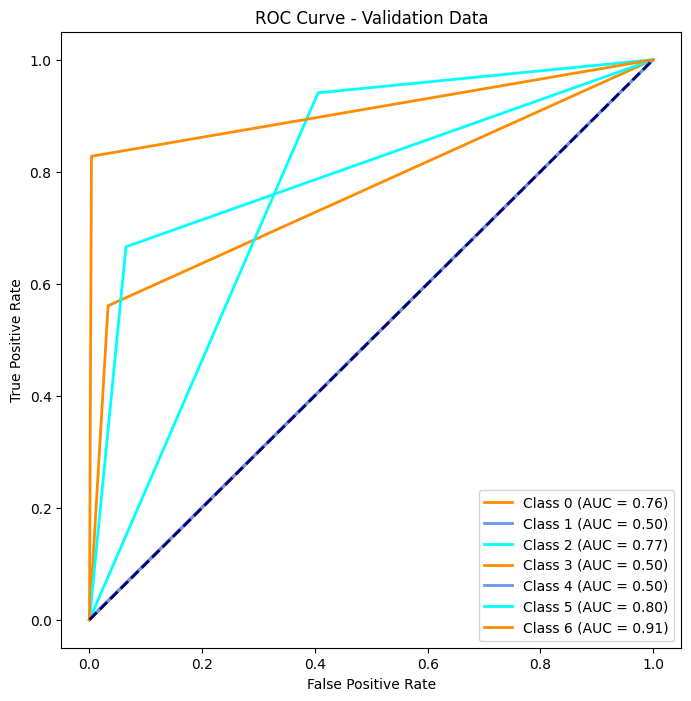

In [10]:
# Confusion matrix for training data
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
cm_train = confusion_matrix(y_train_true, y_train_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Confusion matrix for validation data
y_val_true = val_generator.classes
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
cm_val = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# AUC-ROC curve for training data
y_train_true_binary = label_binarize(y_train_true, classes=np.unique(y_train_true))
y_train_pred_binary = label_binarize(y_train_pred_classes, classes=np.unique(y_train_true))

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(NUM_CLASSES):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_true_binary[:, i], y_train_pred_binary[:, i])
    roc_auc_train[i] = roc_auc_score(y_train_true_binary[:, i], y_train_pred_binary[:, i])

plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC curve for validation data
y_val_true_binary = label_binarize(y_val_true, classes=np.unique(y_val_true))
y_val_pred_binary = label_binarize(y_val_pred_classes, classes=np.unique(y_val_true))

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

for i in range(NUM_CLASSES):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_true_binary[:, i], y_val_pred_binary[:, i])
    roc_auc_val[i] = roc_auc_score(y_val_true_binary[:, i], y_val_pred_binary[:, i])

plt.figure(figsize=(8, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc='lower right')
plt.show()
